In [ ]:
# Import packages
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.python.keras.models import Sequential
from tensorflow.keras import callbacks, optimizers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import VGG16
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import seaborn as sns
import os
import sys
import subprocess


In [ ]:
#Import CIFAR-10 dataset from Keras datasets module
from keras.datasets import cifar10

# Define class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Split training data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [ ]:
#Normalize and convert images to float and convert labels to integers
x_train = (x_train / 255.).astype(np.float32)
y_train = y_train.astype(np.int64)
x_val = (x_val / 255.).astype(np.float32)
y_val = y_val.astype(np.int64)
x_test = (x_test / 255.).astype(np.float32)

In [ ]:
x_train.shape


(40000, 32, 32, 3)

In [ ]:
# Convert labels to categorical (one-hot encoding)
y_train_cat = tf.keras.utils.to_categorical(y_train, 10)
y_val_cat = tf.keras.utils.to_categorical(y_val, 10)
y_test_cat = tf.keras.utils.to_categorical(y_test, 10)

In [ ]:
def resize_images(images):
    return tf.image.resize(images, (48, 48))

x_train_resized = resize_images(x_train).numpy()
x_val_resized = resize_images(x_val).numpy()
x_test_resized = resize_images(x_test).numpy()

In [ ]:
# Add our data-augmentation parameters to ImageDataGenerator (rescaling done previously)
train_datagen = ImageDataGenerator(rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

# No augmentation (rescaling done previously)
test_datagen = ImageDataGenerator()

# Flow training images in batches of 32 using train_datagen generator
train_generator = train_datagen.flow(x_train,
                                     y_train_cat,
                                     batch_size=32,
                                     shuffle=True)  # Shuffle the data

# Flow validation images in batches of 32 using test_datagen generator
validation_generator = test_datagen.flow(x_val,
                                         y_val_cat,
                                         batch_size=32,
                                         shuffle=False)



In [ ]:
# Initialize the base VGG16 model
pre_trained_model_vgg = VGG16(weights='imagenet', include_top=False, input_shape=(48, 48, 3))

In [ ]:
#Unfreeze some layers
#Allow training
pre_trained_model_vgg.trainable = True

In [ ]:
len(pre_trained_model_vgg.layers)

19

In [ ]:
# Fine-tune from layer 16 onwards
fine_tune_at = 16

# Freeze all the layers before the `fine_tune_at` layer
for layer in pre_trained_model_vgg.layers[:fine_tune_at]:
  layer.trainable = False

In [ ]:
pre_trained_model_vgg.output.shape

TensorShape([None, 1, 1, 512])

In [ ]:
#Model
#Flatten
x_vgg = tf.keras.layers.Flatten()(pre_trained_model_vgg.output)
#Add fully connected layer
x_vgg = tf.keras.layers.Dense(1024, activation='relu')(x_vgg)
#Output layer
x_vgg = tf.keras.layers.Dense(10, activation= 'softmax',name='Output')(x_vgg)

# Create the model
model_vgg_fine_tune = Model(pre_trained_model_vgg.input, x_vgg)

In [ ]:
# Set the training parameters
base_learning_rate = 0.0001
model_vgg_fine_tune.compile(loss='categorical_crossentropy',
                             optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
                             metrics=['accuracy'])

In [ ]:
# Train the model.
fine_tune_epochs = 10


history_fine = model_vgg_fine_tune.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs= 20 + fine_tune_epochs,
            validation_steps = 50,
            verbose = 2)

Epoch 1/30
100/100 - 3s - loss: 2.1956 - accuracy: 0.2103 - val_loss: 2.0584 - val_accuracy: 0.3388 - 3s/epoch - 32ms/step
Epoch 2/30
100/100 - 2s - loss: 1.9853 - accuracy: 0.3197 - val_loss: 1.8554 - val_accuracy: 0.4050 - 2s/epoch - 20ms/step
Epoch 3/30
100/100 - 2s - loss: 1.8600 - accuracy: 0.3569 - val_loss: 1.7391 - val_accuracy: 0.4187 - 2s/epoch - 20ms/step
Epoch 4/30
100/100 - 2s - loss: 1.7766 - accuracy: 0.3822 - val_loss: 1.6360 - val_accuracy: 0.4519 - 2s/epoch - 20ms/step
Epoch 5/30
100/100 - 2s - loss: 1.6807 - accuracy: 0.4169 - val_loss: 1.5547 - val_accuracy: 0.4850 - 2s/epoch - 19ms/step
Epoch 6/30
100/100 - 2s - loss: 1.6392 - accuracy: 0.4291 - val_loss: 1.5110 - val_accuracy: 0.4856 - 2s/epoch - 20ms/step
Epoch 7/30
100/100 - 2s - loss: 1.6117 - accuracy: 0.4369 - val_loss: 1.4777 - val_accuracy: 0.4831 - 2s/epoch - 19ms/step
Epoch 8/30
100/100 - 2s - loss: 1.5895 - accuracy: 0.4456 - val_loss: 1.4238 - val_accuracy: 0.5019 - 2s/epoch - 20ms/step
Epoch 9/30
100/1

In [ ]:
#Evaluation on the test dataset
test_loss, test_acc = model_vgg_fine_tune.evaluate(x_test_resized, y_test_cat, verbose=0)

print('Test accuracy:', test_acc)

Test accuracy: 0.524399995803833


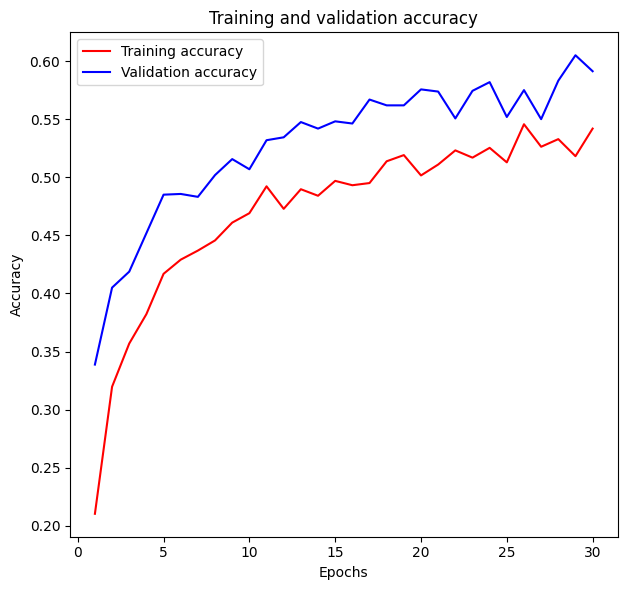

In [ ]:
#Plot validation and training accuracy over epochs
# Extract metrics
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']
loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Make predictions on the test data
y_pred = model_vgg_fine_tune.predict(x_test_resized)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate precision, recall, and F1-score
precision = precision_score(y_test, y_pred_classes, average='weighted')
recall = recall_score(y_test, y_pred_classes, average='weighted')
f1 = f1_score(y_test, y_pred_classes, average='weighted')

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-score: {f1}')

313/313 [==============================] - 2s 5ms/step
Precision: 0.5795885371155918
Recall: 0.5244
F1-score: 0.5320371789202184


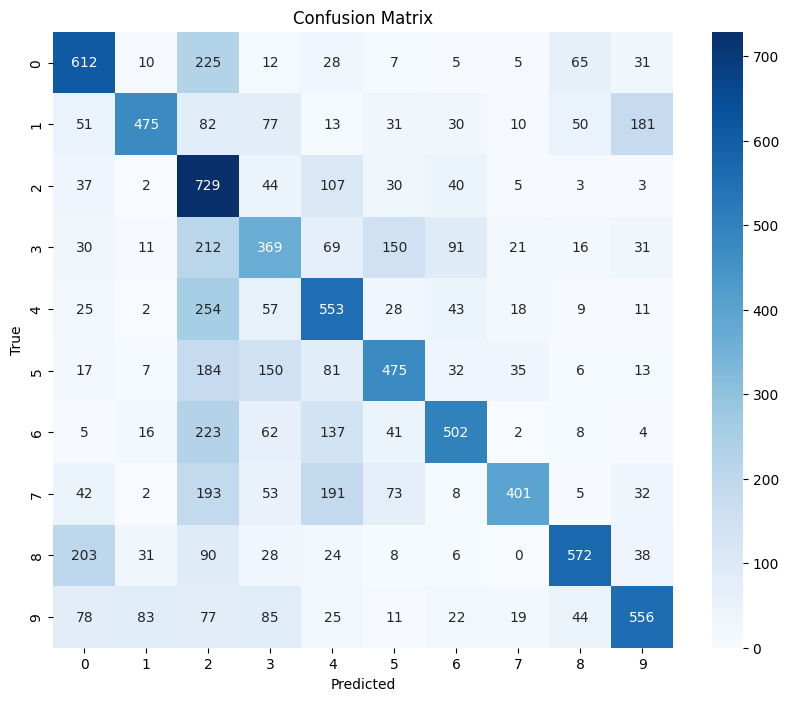

In [ ]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Visualize the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()